In [1]:
import os
import sys
import polars as pl
import polars.selectors as cs

from datetime import datetime

PROJECT_PATH = os.path.abspath(os.path.join(".."))
PIPELINE_PATH = os.path.join(PROJECT_PATH, "pipeline")
DATA_DIRECTORY = os.path.join(PROJECT_PATH, "data")

unflagged_data = False

if PIPELINE_PATH not in sys.path:
    sys.path.append(PIPELINE_PATH)
    
from utils.paths import PROCESSED_PICARRO_DATA_DIRECTORY, POSTPROCESSED_DATA_DIRECTORY
from utils.import_data import import_acropolis_system_data
from utils.plot_dataframes import plot_sensor_measurement, plot_wind_rose, plot_co2_rose

assert(os.path.exists(POSTPROCESSED_DATA_DIRECTORY))
assert(os.path.exists(PROCESSED_PICARRO_DATA_DIRECTORY))

In [2]:
# Filters
start_date = datetime(2025, 2, 18, 0, 0, 0)
end_date = datetime(2025, 2 , 26, 23, 59, 59)

filter = '1h'
ids = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

In [3]:
# Load Picarro Data
# DWD Picarro: "Calibrated_1_min_DWD_Picarro_G2301_413.parquet"
df_p_dwd = pl.scan_parquet(os.path.join(PROCESSED_PICARRO_DATA_DIRECTORY,"Calibrated_1_min_DWD_Picarro_G2301_413.parquet"))
df_p_dwd = df_p_dwd.filter(pl.col("datetime").is_between(start_date, end_date)).collect()

# ICOS Picarro: "Calibrated_1_min_ICOS_Picarro_G2401_529.parquet"
df_p_icos = pl.scan_parquet(os.path.join(PROCESSED_PICARRO_DATA_DIRECTORY,"Calibrated_1_min_ICOS_Picarro_G2401_529.parquet"))
df_p_icos = df_p_icos.filter(pl.col("datetime").is_between(start_date, end_date)).collect()
    
df_p = pl.concat([df_p_dwd,df_p_icos], how="diagonal")
del df_p_dwd, df_p_icos
df_p.head(1).vstack(df_p.tail(1))

system_name,system_id,datetime,picarro_corrected,h2o_reported
str,i32,datetime[ms],f64,f64
"""Picarro_G2401""",529,2025-02-18 00:00:00,470.619122,0.503802
"""Picarro_G2401""",529,2025-02-24 12:55:00,610.96252,0.001298


In [4]:
# Load ACROPOLIS Data
all_systems = []

for id in ids:
    print("Processing system:", id)

    df_system = import_acropolis_system_data(
            years=[2024,2025],
            target_directory=POSTPROCESSED_DATA_DIRECTORY,
            id=id,
            prefix="1min"
        ).group_by_dynamic("datetime", every=filter, group_by=["system_id", "system_name"]) \
            .agg([
                  cs.numeric().mean(),
                  pl.col("gmp343_corrected").std().alias("gmp343_corrected_std"),
                  pl.col("gmp343_corrected").var().alias("gmp343_corrected_var")
              ]) \
        .filter(pl.col("datetime").is_between(start_date, end_date))
        
    all_systems.append(df_system)
    
del df_system
df = pl.concat(all_systems, how="diagonal").collect()
df.head(1).vstack(df.tail(1))

Processing system: 1
Processing system: 2
Processing system: 3
Processing system: 4
Processing system: 5
Processing system: 6
Processing system: 7
Processing system: 8
Processing system: 9
Processing system: 10
Processing system: 11
Processing system: 12
Processing system: 13
Processing system: 14
Processing system: 15
Processing system: 16
Processing system: 17
Processing system: 18
Processing system: 19
Processing system: 20


system_id,system_name,datetime,ts,gmp343_raw,gmp343_compensated,gmp343_filtered,gmp343_temperature,bme280_temperature,bme280_humidity,bme280_pressure,sht45_temperature,sht45_humidity,gmp343_edge_corrected,gmp343_edge_dry,h2o_ah,h2o_v%,bme280_h2o_v%,gmp343_dry,slope,intercept,slope_interpolated,intercept_interpolated,gmp343_corrected,wxt532_direction_min,wxt532_direction_avg,wxt532_direction_max,wxt532_speed_min,wxt532_speed_avg,wxt532_speed_max,wxt532_last_update_time,wxt532_temperature,wxt532_heating_voltage,wxt532_supply_voltage,wxt532_reference_voltage,enclosure_bme280_temperature,enclosure_bme280_humidity,enclosure_bme280_pressure,raspi_cpu_temperature,raspi_disk_usage,raspi_cpu_usage,raspi_memory_usage,ups_powered_by_grid,ups_battery_is_fully_charged,ups_battery_error_detected,ups_battery_above_voltage_threshold,cal_gmp343_slope,cal_gmp343_intercept,cal_sht_45_offset,gmp343_corrected_std,gmp343_corrected_var
i32,str,datetime[ms],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,"""acropolis-1""",2025-02-18 00:00:00,1.7398e12,467.252222,534.470278,534.491944,29.9975,26.307639,10.231306,941.590222,26.237306,13.192222,488.341944,537.691667,4.003932,0.594927,0.461387,537.690622,0.978602,-37.52262,0.979569,-38.101277,488.603736,1.7,133.513333,356.9,0.146667,0.985,2.121667,1.7398e9,null,null,null,null,33.0775,14.97,958.496667,52.093333,0.24,0.021,0.073,1.0,1.0,0.0,0.0,0.98,-36.77,0.28,4.773653,22.787758
20,"""acropolis-20""",2025-02-25 08:00:00,1.7405e12,412.957895,472.954386,473.037719,28.751754,24.243772,20.287368,933.893509,24.881495,24.150243,464.262281,477.913158,6.849794,1.021948,0.858486,477.922039,1.011658,-19.43961,1.011658,-19.43961,464.053833,171.421053,206.136842,249.0,0.621053,1.436842,2.226316,1.7405e9,null,null,null,null,31.414211,15.764211,951.174211,51.363158,0.248,0.020895,0.074474,1.0,1.0,0.0,0.0,null,null,null,6.628763,43.940499


In [12]:
plot_sensor_measurement(df,ids,col_name="enclosure_bme280_humidity")

In [ ]:
plot_sensor_measurement(df,ids,col_name="gmp343_temperature")

In [ ]:
plot_sensor_measurement(df,ids=ids,col_name="gmp343_corrected")

In [ ]:
plot_sensor_measurement(df,ids=ids,col_name="wxt532_speed_avg")

In [ ]:
plot_sensor_measurement(df,ids,col_name="sht45_humidity")

In [ ]:
plot_sensor_measurement(df,ids,col_name="h2o_v%")

In [ ]:
plot_sensor_measurement(df,ids,col_name="bme280_humidity")

In [ ]:
plot_sensor_measurement(df,ids,col_name="bme280_h2o_v%")

In [ ]:
df_plot = df.with_columns(diff_inflow_humidity = (pl.col("sht45_humidity") - pl.col("bme280_humidity"))) \
    .filter(pl.col("diff_inflow_humidity").is_not_nan()) \
    .select("datetime", "diff_inflow_humidity", "system_id") \
    .sort("system_id")
    
plot_sensor_measurement(df_plot,ids,col_name="diff_inflow_humidity")

In [ ]:
df_plot = df.with_columns(diff_inflow_humidity = (pl.col("h2o_v%") - pl.col("bme280_h2o_v%"))) \
    .filter(pl.col("diff_inflow_humidity").is_not_nan()) \
    .select("datetime", "diff_inflow_humidity", "system_id") \
    .sort("system_id")
    
plot_sensor_measurement(df_plot,ids,col_name="diff_inflow_humidity")

In [ ]:
plot_sensor_measurement(df,ids,col_name="sht45_temperature")

In [ ]:
plot_sensor_measurement(df,ids,col_name="bme280_temperature")

In [ ]:
df_plot = df.with_columns(diff_inflow_temperature = (pl.col("sht45_temperature") - pl.col("bme280_temperature"))) \
    .filter(pl.col("diff_inflow_temperature").is_not_nan()) \
    .select("datetime", "diff_inflow_temperature", "system_id") \
    .sort("system_id")
    
plot_sensor_measurement(df_plot,ids,col_name="diff_inflow_temperature")

In [ ]:
plot_sensor_measurement(df,ids,col_name="bme280_pressure")

In [ ]:
plot_sensor_measurement(df,ids,col_name="enclosure_bme280_temperature")

In [ ]:
plot_sensor_measurement(df,ids=ids,col_name="gmp343_raw")

In [ ]:
plot_sensor_measurement(df,ids,col_name="gmp343_compensated")

In [ ]:
plot_sensor_measurement(df,ids,col_name="wxt532_temperature")

In [5]:
# KLEG
plot_co2_rose(df, 1, 'Klenze Gymnasium')

# X
#plot_co2_rose(df, 2, 'X')

# X
#plot_co2_rose(df, 3, 'X')

# X
#plot_co2_rose(df, 4, 'X')

# DLRO
plot_co2_rose(df, 5, 'DLR')

# TUMN
plot_co2_rose(df, 6, 'TUM')

# FB85
#plot_co2_rose(df, 7, 'Blutenburgturm 85m')

# KRDI
plot_co2_rose(df, 8, 'Klinikum Rechts-der-Isar')

# KNPL
plot_co2_rose(df, 9, 'Klinikum Neuperlach')

# SWGG
plot_co2_rose(df, 10, 'Städtisches Willi Graf Gymnasium')

# RFIN
plot_co2_rose(df, 11, 'Rathaus Finsing')

# WKRT
plot_co2_rose(df, 12, 'Walter-Klingenbeck-Realschule')

# RFEL
plot_co2_rose(df, 13, 'Rathaus Feldkirchen')

# FB48
#plot_co2_rose(df, 14, 'Blutenburgturm 48m')

# SWMZ
plot_co2_rose(df, 15, 'Stadtwerke München Zentrale')

# SMAI
plot_co2_rose(df, 16, 'Schule Maisach')

# KBOG
#plot_co2_rose(df, 17, 'Klinikum Bogenhausen')

# SBBG
plot_co2_rose(df, 18, 'Städtisches Bertolt Brecht Gymnasium')

# X
#plot_o2_rose(df, 19, 'X')

# LGRO
plot_co2_rose(df, 20, 'LMU Großhadern')



In [6]:
# KLEG
plot_wind_rose(df, 1, 'Klenze Gymnasium')

# X
#plot_wind_rose(df, 2, 'X')

# X
#plot_wind_rose(df, 3, 'X')

# X
#plot_wind_rose(df, 4, 'X')

# DLRO
plot_wind_rose(df, 5, 'DLR')

# TUMN
plot_wind_rose(df, 6, 'TUM')

# FB85
#plot_wind_rose(df, 7, 'Blutenburgturm 85m')

# KRDI
plot_wind_rose(df, 8, 'Klinikum Rechts-der-Isar')

# KNPL
plot_wind_rose(df, 9, 'Klinikum Neuperlach')

# SWGG
plot_wind_rose(df, 10, 'Städtisches Willi Graf Gymnasium')

# RFIN
plot_wind_rose(df, 11, 'Rathaus Finsing')

# WKRT
plot_wind_rose(df, 12, 'Walter-Klingenbeck-Realschule')

# RFEL
plot_wind_rose(df, 13, 'Rathaus Feldkirchen')

# FB48
#plot_wind_rose(df, 14, 'Blutenburgturm 48m')

# SWMZ
plot_wind_rose(df, 15, 'Stadtwerke München Zentrale')

# SMAI
plot_wind_rose(df, 16, 'Schule Maisach')

# KBOG
#plot_wind_rose(df, 17, 'Klinikum Bogenhausen')

# SBBG
plot_wind_rose(df, 18, 'Städtisches Bertolt Brecht Gymnasium')

# X
#plot_o2_rose(df, 19, 'X')

# LGRO
plot_wind_rose(df, 20, 'LMU Großhadern')



In [ ]:
plot_sensor_measurement(df,ids,col_name="wxt532_direction_avg")

In [ ]:
plot_sensor_measurement(df,ids,col_name="raspi_cpu_usage")

In [ ]:
plot_sensor_measurement(df,ids,col_name="raspi_memory_usage")


In [ ]:
plot_sensor_measurement(df,ids,col_name="raspi_disk_usage")


In [ ]:
plot_sensor_measurement(df,ids,col_name="raspi_cpu_temperature")

In [ ]:
plot_sensor_measurement(df,ids,col_name="enclosure_bme280_pressure")

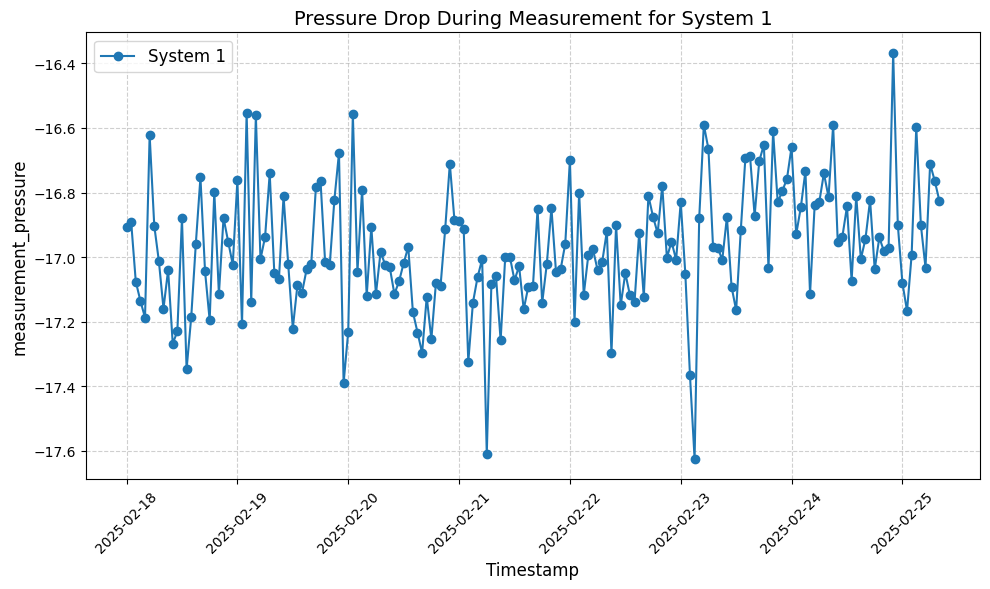

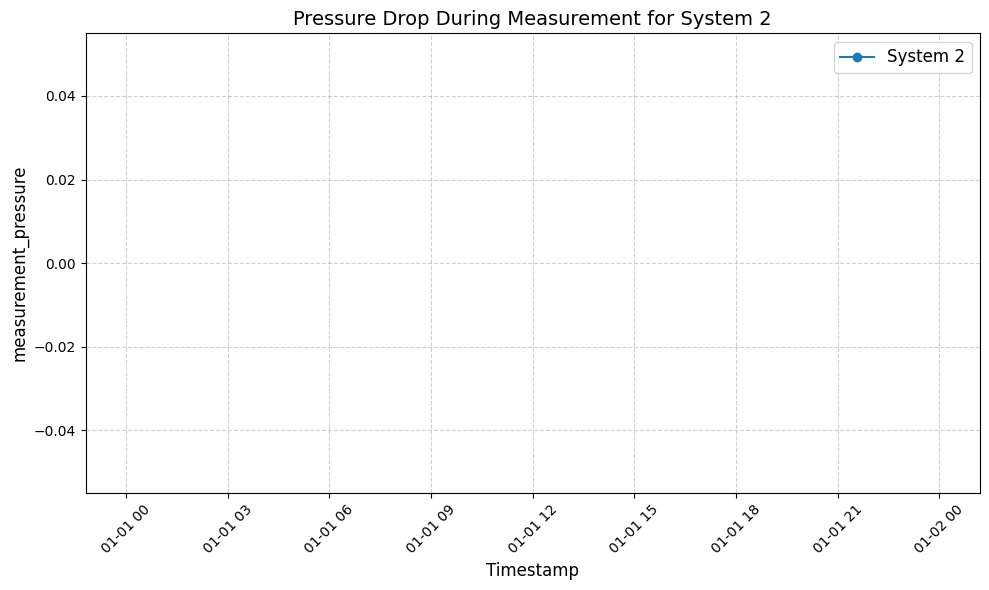

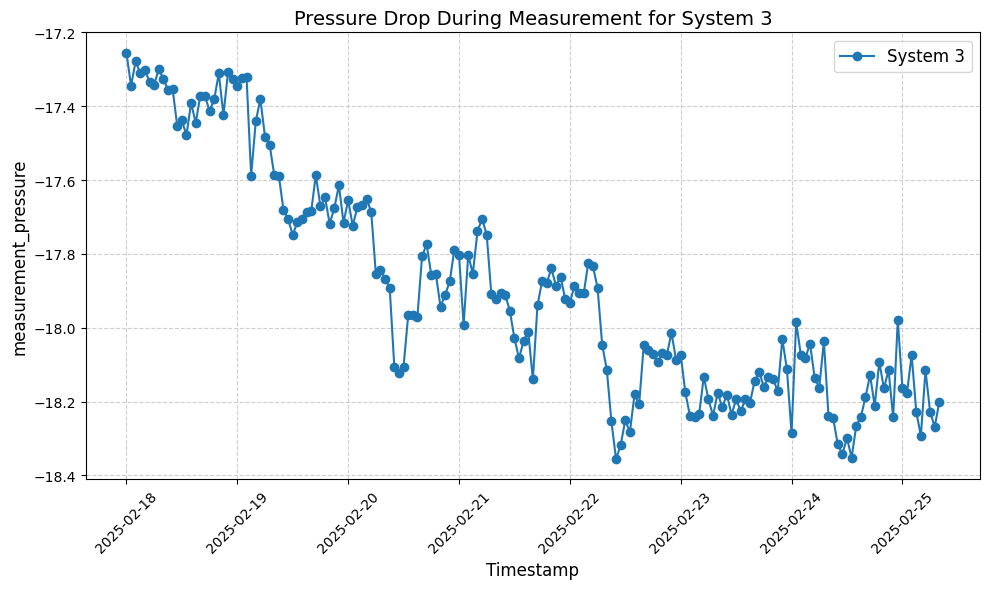

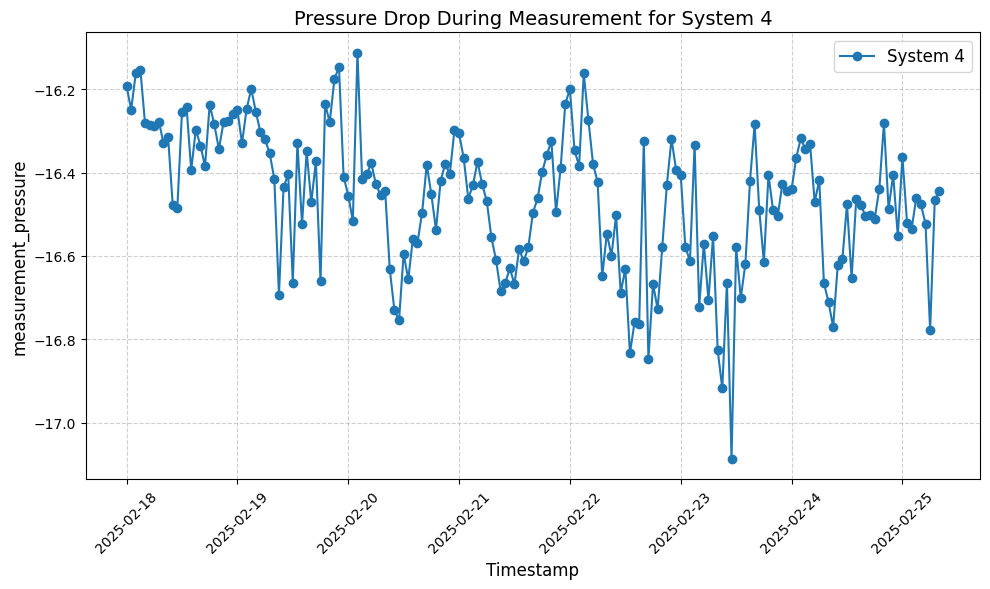

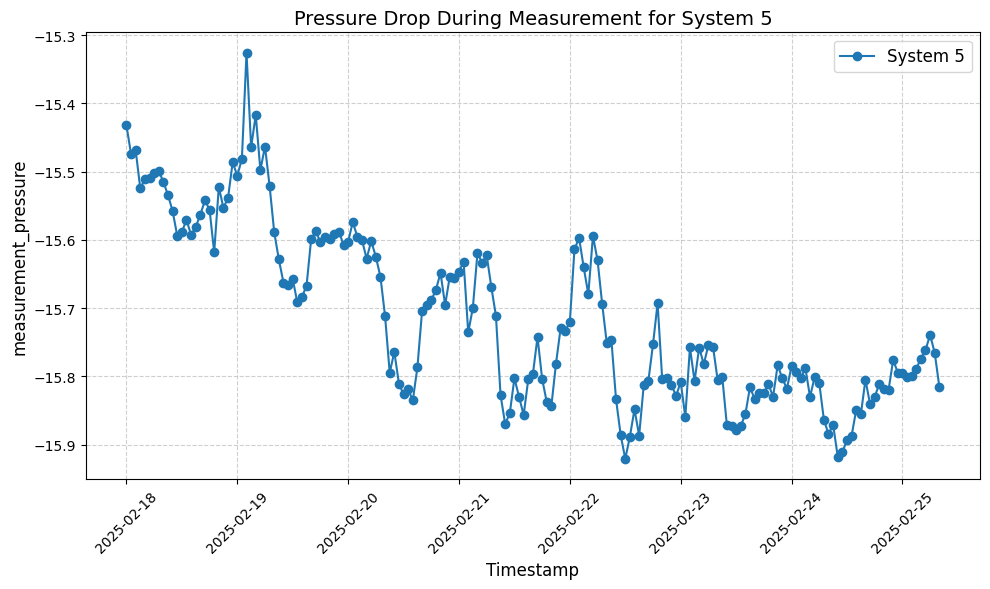

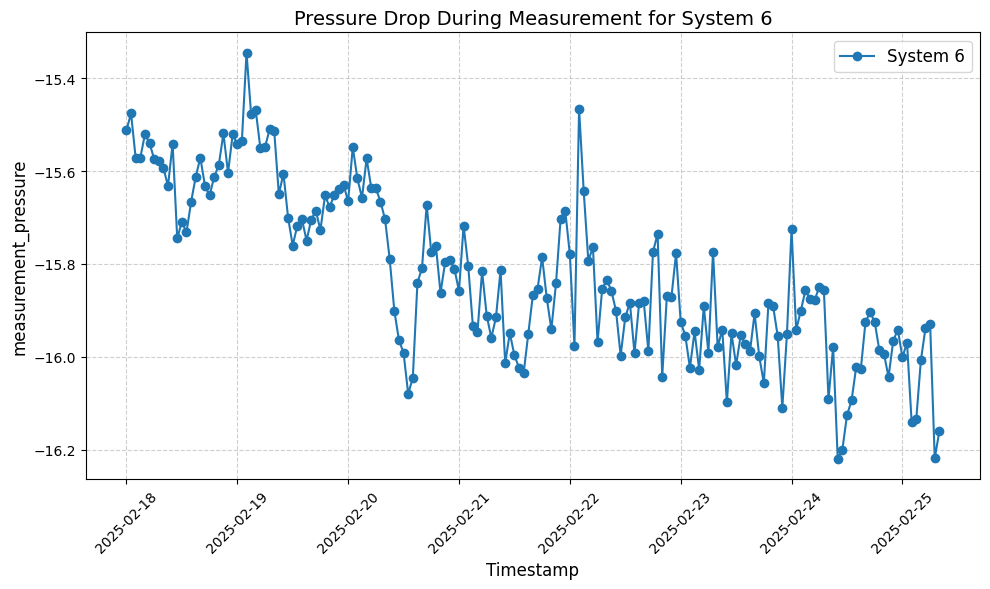

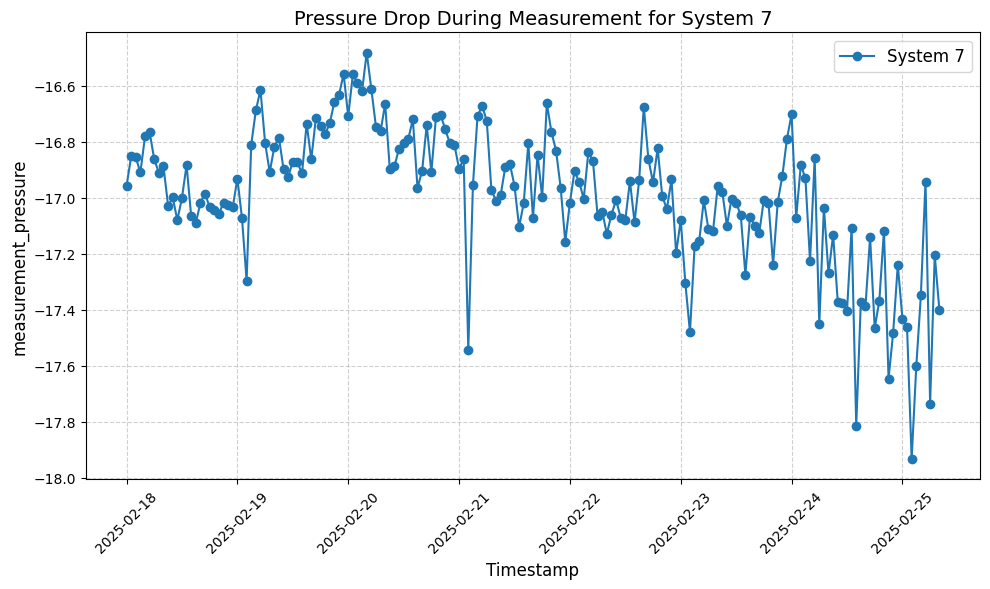

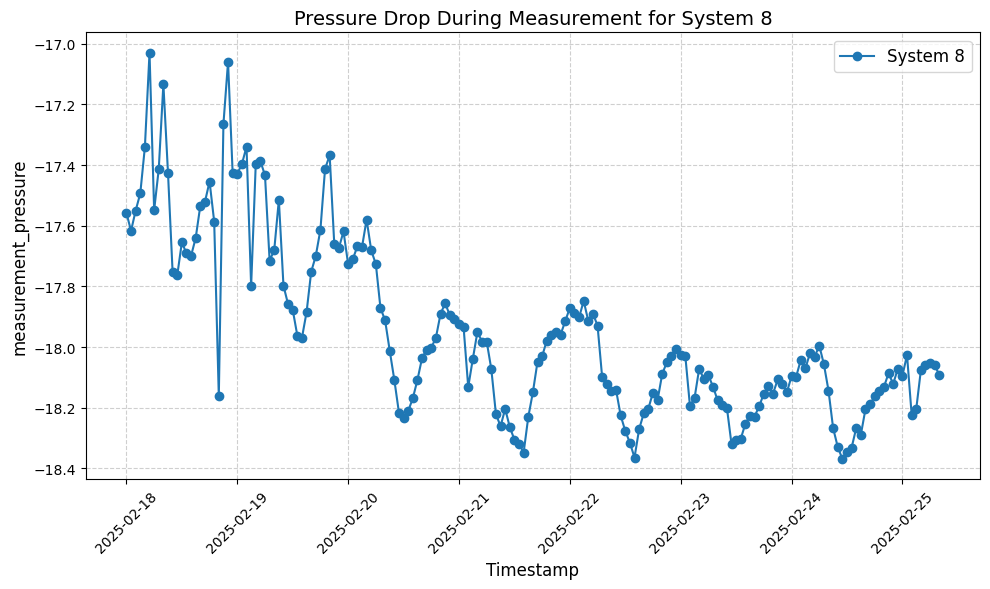

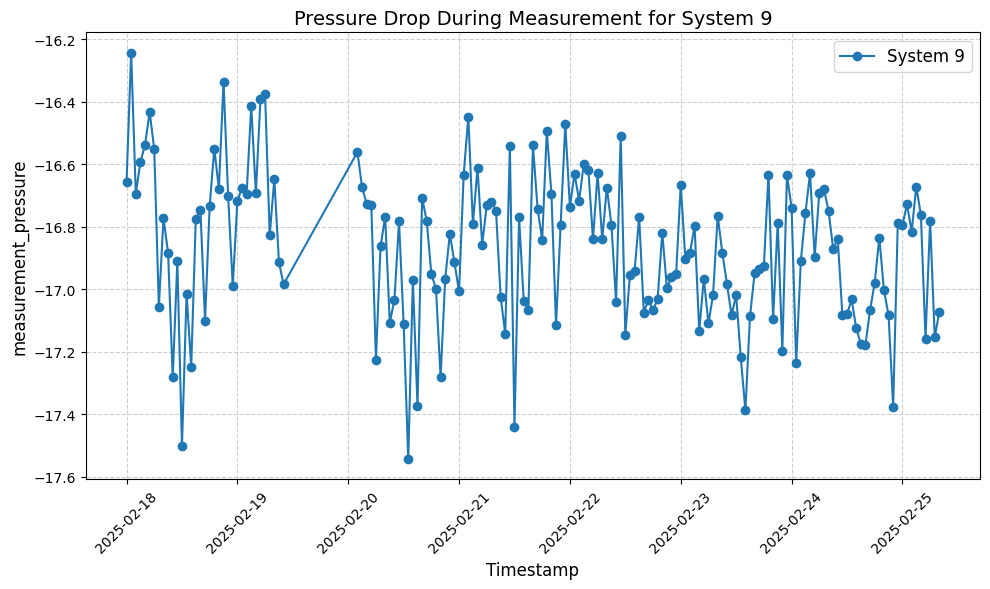

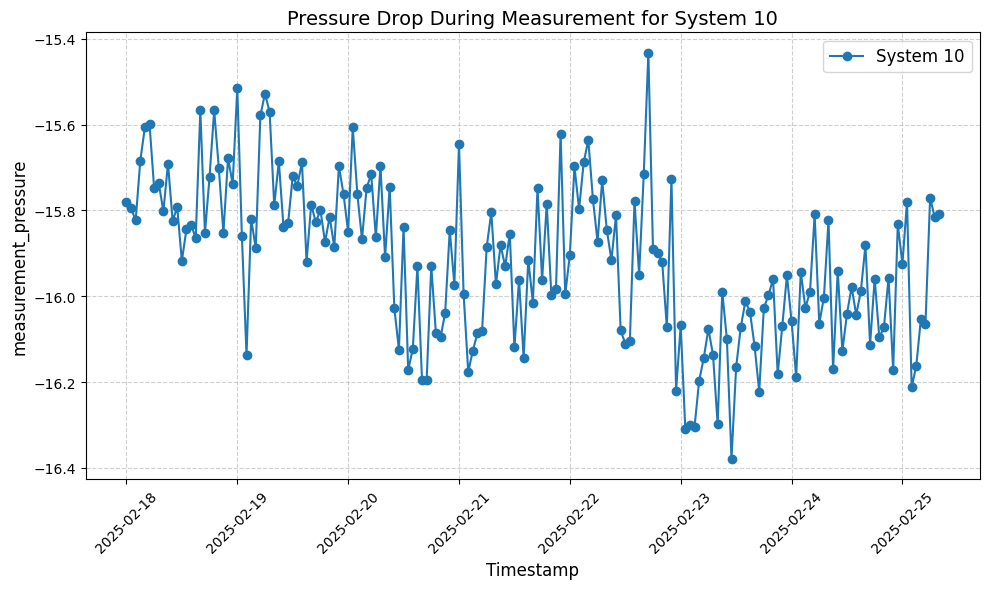

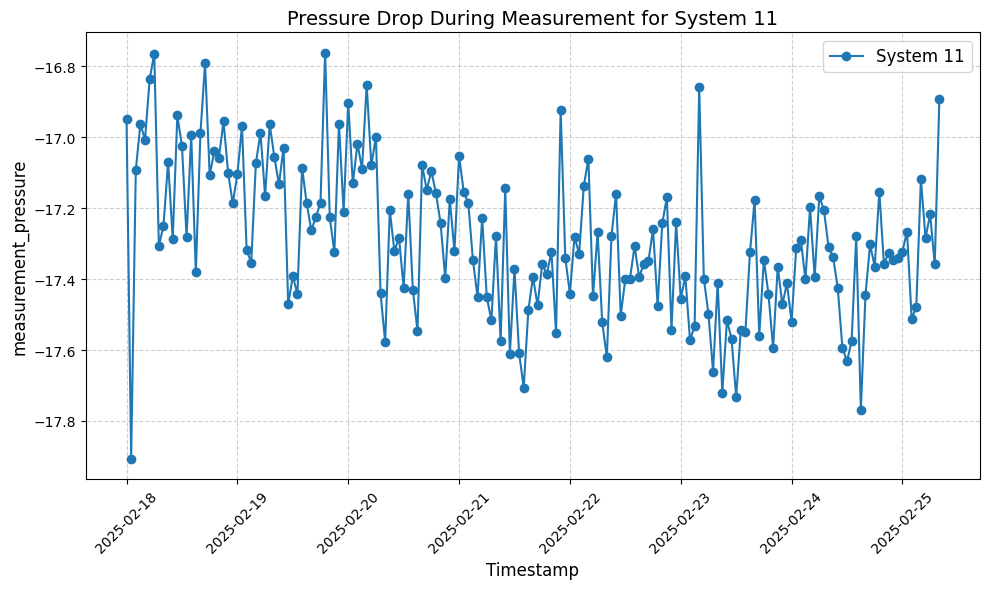

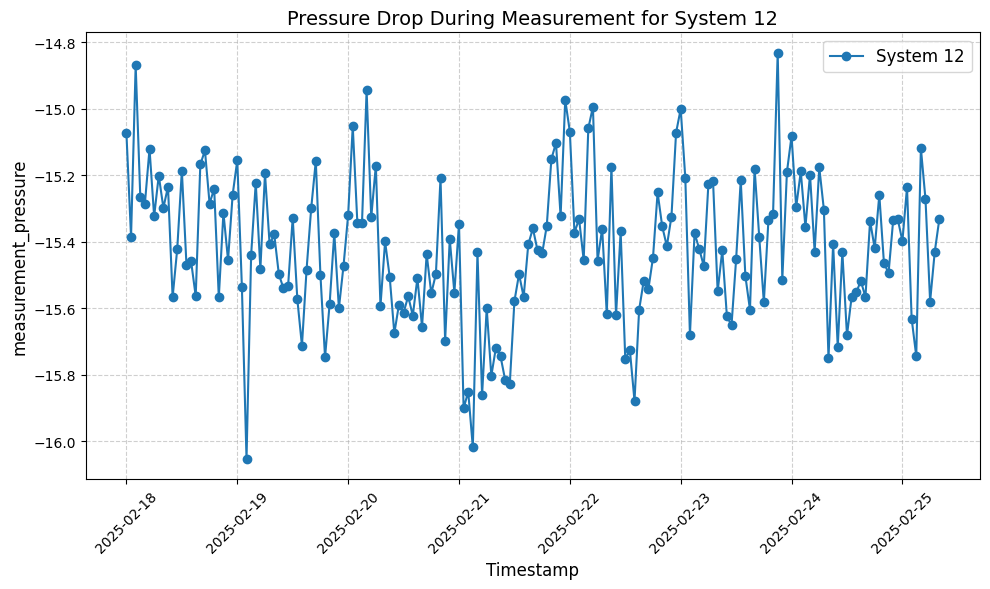

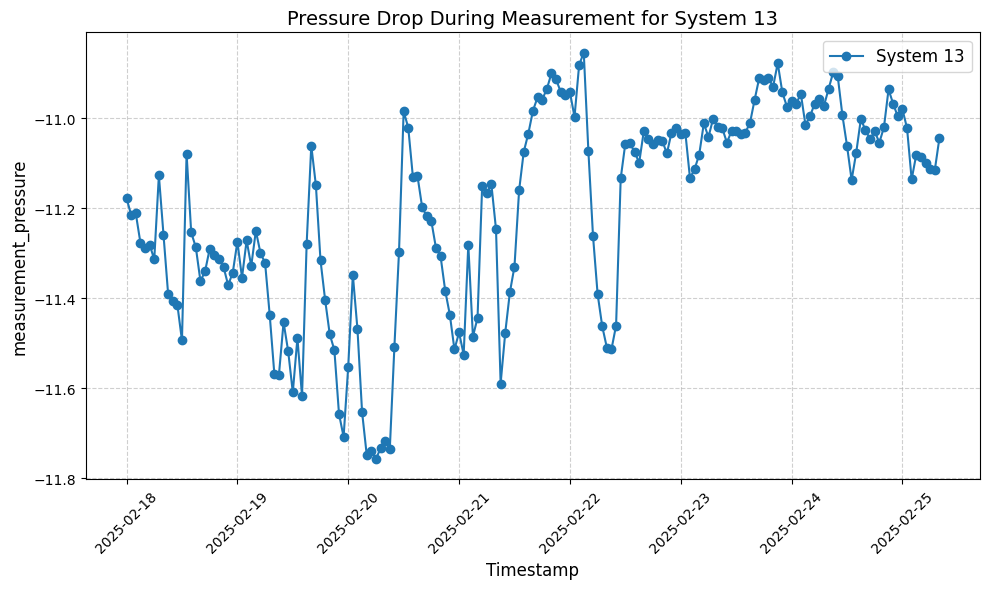

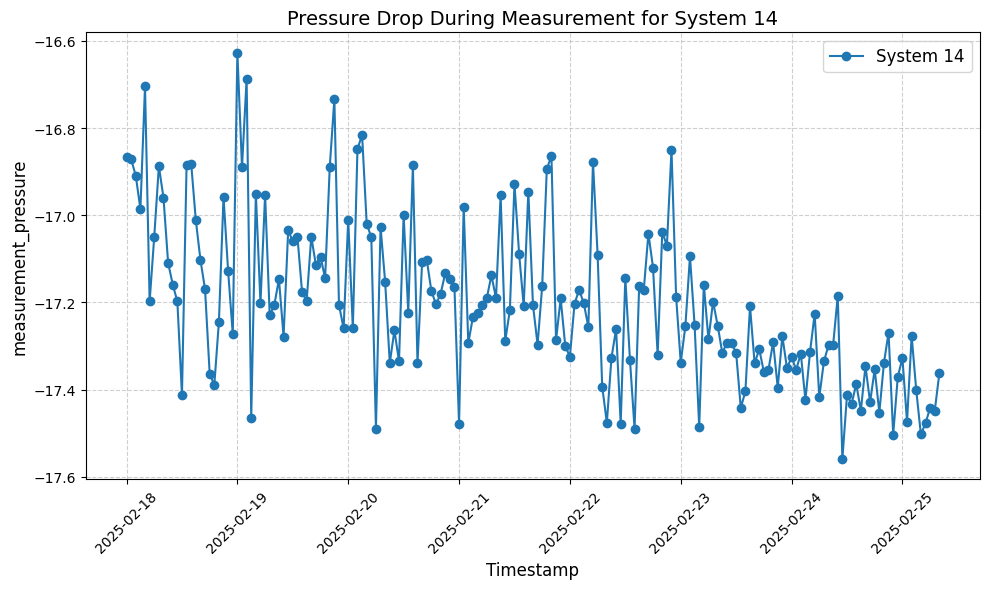

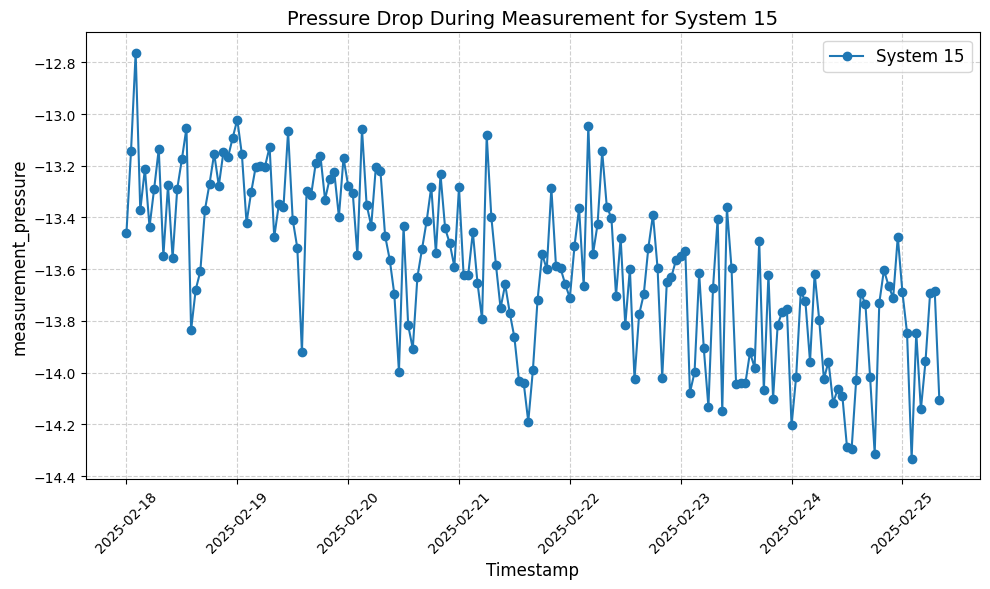

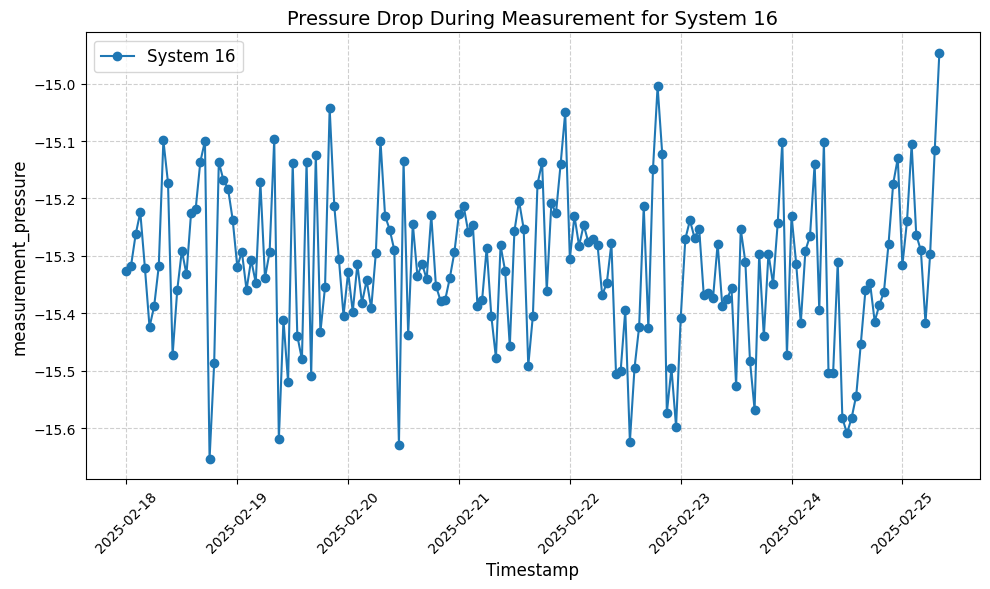

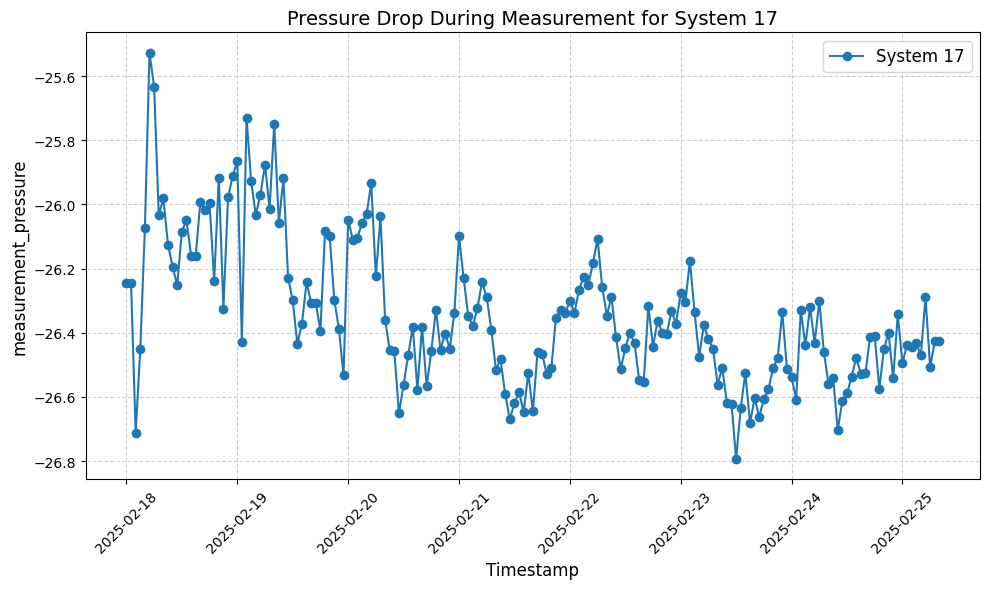

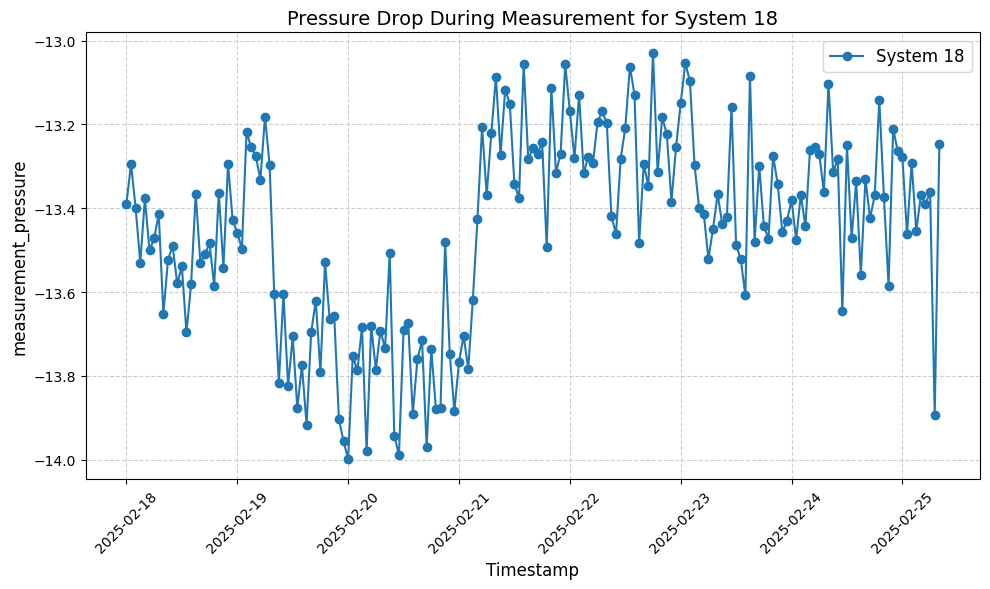

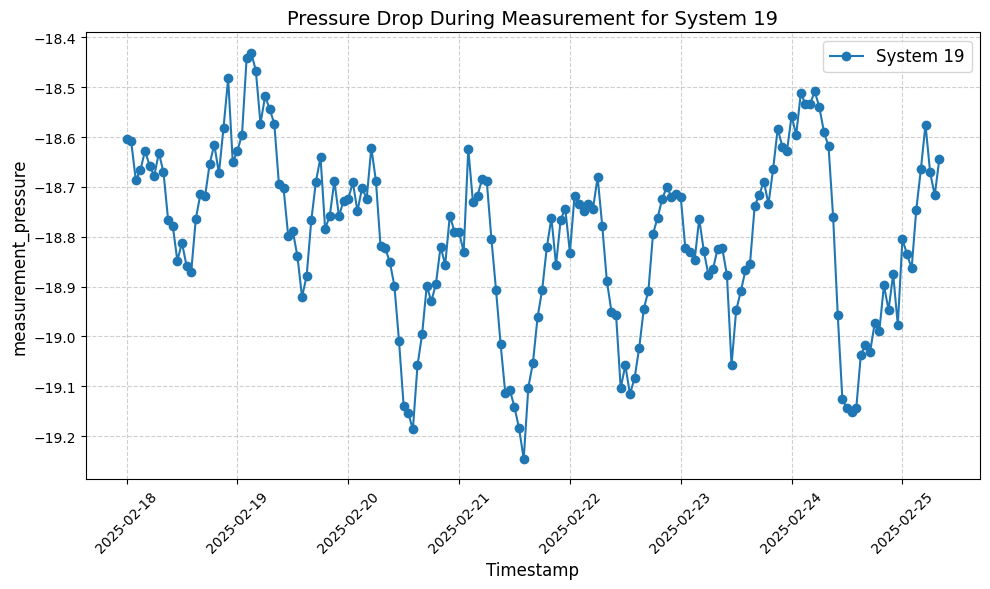

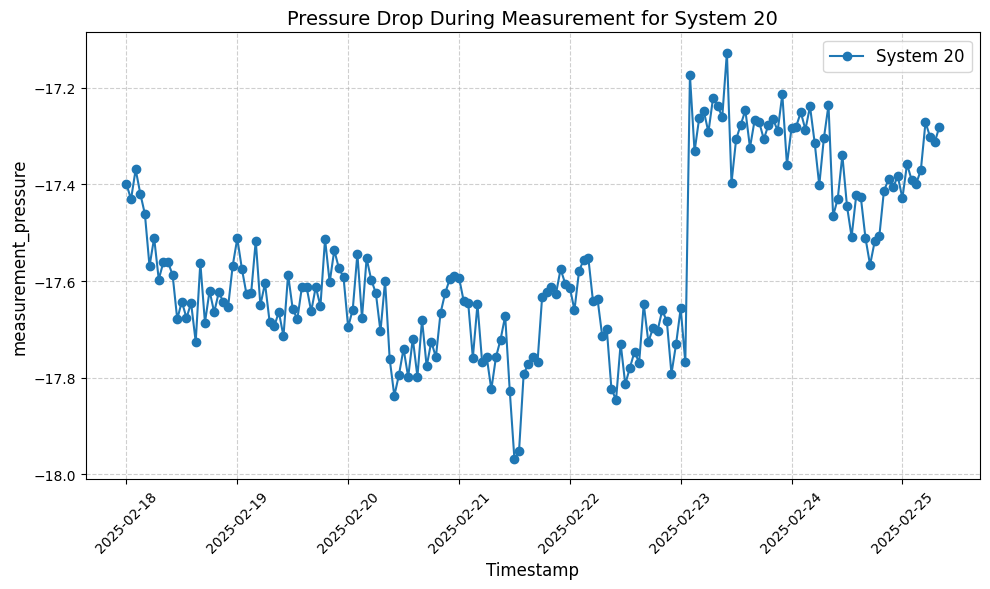

In [7]:
df_plot = df.with_columns(pl.col("enclosure_bme280_pressure").forward_fill().backward_fill()) \
    .with_columns(measurement_pressure = (pl.col("bme280_pressure") - pl.col("enclosure_bme280_pressure"))) \
    .filter(pl.col("measurement_pressure").is_not_nan()) \
    .select("datetime", "measurement_pressure", "system_id") \
    .sort("system_id")
    

import matplotlib.pyplot as plt
import polars as pl

for id in ids:
    
    # Filter data for the given system_id
    filtered_df = (
    df_plot.filter(pl.col("system_id") == id)
)

    # Plot using Matplotlib
    plt.figure(figsize=(10, 6))
    plt.plot(
        filtered_df["datetime"], 
        filtered_df["measurement_pressure"], 
        marker='o', 
        label=f"System {id}"
    )

    # Customize plot
    plt.title(f"Pressure Drop During Measurement for System {id}", fontsize=14)
    plt.xlabel("Timestamp", fontsize=12)
    plt.ylabel("measurement_pressure", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Calibration Data

In [ ]:
df_plot = df.group_by_dynamic("datetime", every='1d', by=["system_id", "cal_sht45_humidity"]) \
    .agg(pl.all().exclude(["datetime","cal_sht45_humidity"]).min()) \
    .select("datetime", "cal_sht45_humidity", "system_id") \



plot_sensor_measurement(df_plot,ids,col_name="cal_sht45_humidity",filter='1h')

In [ ]:
df_plot = df.with_columns(pl.col("enclosure_bme280_pressure").forward_fill().backward_fill()) \
    .with_columns(calibration_pressure = (pl.col("cal_bme280_pressure") - pl.col("enclosure_bme280_pressure"))) \
    .filter(pl.col("calibration_pressure").is_not_nan()) \
    .select("datetime", "calibration_pressure", "system_id") \
    .sort("system_id")

import matplotlib.pyplot as plt
import polars as pl

for id in ids:
    
    # Filter data for the given system_id
    filtered_df = (
    df_plot.filter(pl.col("system_id") == id)
)

    # Plot using Matplotlib
    plt.figure(figsize=(10, 6))
    plt.plot(
        filtered_df["datetime"], 
        filtered_df["calibration_pressure"], 
        marker='o', 
        label=f"System {id}"
    )

    # Customize plot
    plt.title(f"Pressure Drop During Calibration for System {id}", fontsize=14)
    plt.xlabel("Timestamp", fontsize=12)
    plt.ylabel("Calibration Pressure", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [ ]:
plot_sensor_measurement(df,ids,col_name="cal_bottle_id")

In [ ]:
plot_sensor_measurement(df,ids,col_name="cal_gmp343_filtered")

In [ ]:
plot_sensor_measurement(df,ids,col_name="cal_sht45_humidity")

In [ ]:
plot_sensor_measurement(df,ids,col_name="cal_sht45_temperature")

In [ ]:
plot_sensor_measurement(df,ids,col_name="cal_gmp343_temperature")

In [ ]:
plot_sensor_measurement(df,ids,col_name="cal_bme280_temperature")

In [ ]:
plot_sensor_measurement(df,ids,col_name="cal_bme280_humidity")

In [ ]:
plot_sensor_measurement(df,ids,col_name="cal_sht45_humidity")

In [ ]:
plot_sensor_measurement(df,ids,col_name="cal_bme280_pressure")

In [ ]:
# Plot 400ppm Calibration Bottle 
plot_sensor_measurement(df,ids,col_name="cal_gmp343_filtered",cut_above= 450,cut_below=350)

In [ ]:
# Plot 800ppm Calibration Bottle 
plot_sensor_measurement(df,ids,col_name="cal_gmp343_filtered",cut_below=460)